In [33]:
model_path = '../Models'
eval_path = './'

model_names = [
    'resnet_5k_best.pth',
    'resnet_pt_5k_best.pth',
    'googlenet_5k_best.pth',
    'googlenet_pt_5k_best.pth',
    'vgg_5k_best.pth'
]

# Train Result
<li><b>resnet_5k_best.pth</b>: ResNet18 with dataset 5K images</li>
<li><b>resnet_pt_5k_best.pth</b>: ResNet18 pre-trained with dataset 5K images</li>
<li><b>googlenet_5k_best.pth</b>: GoogleNet with dataset 5K images</li>
<li><b>googlenet_pt_5k_best.pth</b>: GoogleNet pre-trained with dataset 5K images</li>
<li><b>vgg_5k_best.pth</b>: VGG16 with dataset 5K images</li>
<li><b>vgg_pt_5k_best.pth</b>: VGG16 pre-trained with dataset 5K images</li>

## Training vs Accuracy Result

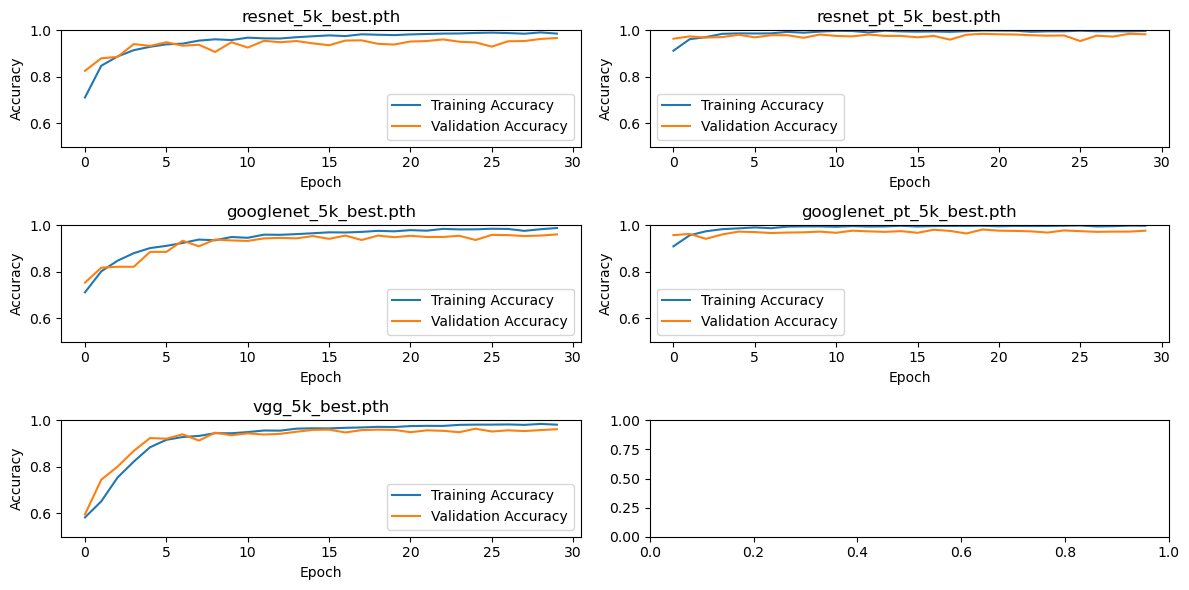

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt



# Set up subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 6))
axs = axs.flatten()  # flatten 2x2 grid to list for easy indexing

for idx, model_name in enumerate(model_names):
    model_state_path = os.path.join(model_path, model_name)
    if not os.path.exists(model_state_path):
        raise FileNotFoundError(f"Model not found: {model_state_path}. Please run model training first.")

    model_acc_path = os.path.join(eval_path, model_name + '_train_acc.csv')
    if not os.path.exists(model_acc_path):
        raise FileNotFoundError(f"Training accuracy history not found: {model_acc_path}. Please run model training first.")

    # Load accuracy data
    df_acc = pd.read_csv(model_acc_path)

    # Plot on subplot
    ax = axs[idx]
    ax.plot(df_acc['train'], label='Training Accuracy')
    ax.plot(df_acc['test'], label='Validation Accuracy')
    ax.set_title(model_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0.5, 1.0)
    ax.legend()

plt.tight_layout()
plt.show()

## Model Summary

In [37]:
all_summaries = []

for model_name in model_names:
    model_sum_path = os.path.join(eval_path, model_name + '_train_sum.csv')
    if not os.path.exists(model_sum_path):
        raise FileNotFoundError(f"Training summary not found: {model_sum_path}. Please run model training first.")
    
    df_sum = pd.read_csv(model_sum_path)
    
    # Optionally add a column to indicate which model this summary is from
    df_sum['model'] = model_name
    
    all_summaries.append(df_sum)

# Combine all summaries into one DataFrame
df_combined = pd.concat(all_summaries, ignore_index=True)

print(df_combined)


   Unnamed: 0                      mode    device  time_elapsed  best_epoch  best_acc                     model
0           0        resnet_5k_best.pth  Tesla T4    965.127540          29     0.967        resnet_5k_best.pth
1           0     resnet_pt_5k_best.pth  Tesla T4   1061.532705          19     0.985     resnet_pt_5k_best.pth
2           0     googlenet_5k_best.pth  Tesla T4   1044.936090          29     0.961     googlenet_5k_best.pth
3           0  googlenet_pt_5k_best.pth  Tesla T4   1105.777221          19     0.982  googlenet_pt_5k_best.pth
4           0           vgg_5k_best.pth  Tesla T4   2133.302468          24     0.964           vgg_5k_best.pth
